# Stochastic Optimization

## 3.1 Genetic Algorithms

<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" align="left" src="https://i.creativecommons.org/l/by-sa/4.0/80x15.png" /></a>&nbsp;| Dennis G. Wilson | <a href="https://supaerodatascience.github.io/stochastic/">https://supaerodatascience.github.io/stochastic/</a>

<img src="imgs/ga.png">

## Population

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import math

In [2]:
n_cities = 10
cities = np.random.rand(n_cities, 2)
rng = np.random.default_rng()
order0 = rng.permutation(n_cities)
order1 = rng.permutation(n_cities)
print(order0)
print(order1)

[6 0 8 2 7 9 5 4 3 1]
[4 5 8 0 6 9 7 2 1 3]


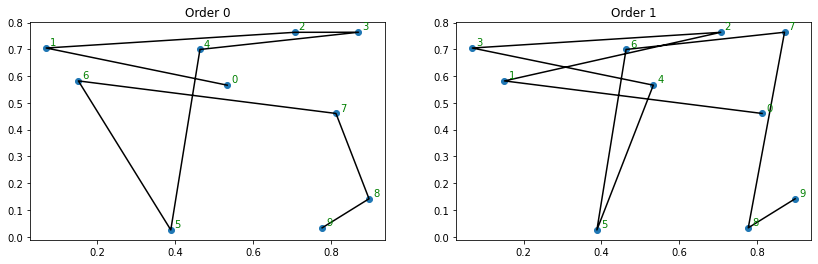

In [3]:
fig = plt.figure(figsize=(14, 4))
ax = plt.subplot(1, 2, 1)
ind = order0
plt.title("Order 0")
ax.scatter(cities[ind, 0], cities[ind, 1])
ax.plot(cities[ind, 0], cities[ind, 1], 'k')
for i in range(n_cities):
    ax.annotate(i, (cities[ind[i], 0]+0.01, cities[ind[i], 1]+0.01), c='g')
ax = plt.subplot(1, 2, 2)
ind = order1
plt.title("Order 1")
ax.scatter(cities[ind, 0], cities[ind, 1])
ax.plot(cities[ind, 0], cities[ind, 1], 'k')
for i in range(n_cities):
    ax.annotate(i, (cities[ind[i], 0]+0.01, cities[ind[i], 1]+0.01), c='g')

In [4]:
n_population = 100
population = np.array([rng.permutation(n_cities) for i in range(n_population)])
population[:5]

array([[3, 7, 5, 0, 8, 6, 1, 2, 9, 4],
       [0, 1, 4, 3, 2, 6, 7, 5, 9, 8],
       [7, 1, 5, 0, 4, 8, 3, 6, 2, 9],
       [1, 3, 5, 4, 7, 2, 6, 9, 0, 8],
       [7, 1, 3, 8, 0, 6, 4, 2, 9, 5]])

## Evaluation

In [5]:
d = np.zeros((n_cities, n_cities))
for i in range(n_cities):
    for j in range(i):
        d[i, j] = np.sqrt((cities[i, 0] - cities[j, 0])**2 + (cities[i,1] - cities[j, 1])**2)
        d[j, i] = d[i, j]
d[:3, :3]

array([[0.        , 0.97657993, 0.80403451],
       [0.97657993, 0.        , 0.73669318],
       [0.80403451, 0.73669318, 0.        ]])

In [6]:
def total_distance(order, distances):
    t = 0
    for i in range(1, len(order)):
        t += distances[order[i-1], order[i]]
    return t

In [7]:
print("order 0:", total_distance(order0, d))
print("order 1:", total_distance(order1, d))

order 0: 4.149977226075222
order 1: 4.931839143531943


In [8]:
def evaluate(population, distances):
    fitness = np.zeros(len(population))
    for i in range(len(population)):
        fitness[i] = total_distance(population[i], distances)
    return fitness

In [9]:
fitness = evaluate(population, d)
for i in range(5):
    print(population[i], fitness[i])
print("Minimum: ")
print(population[np.argmin(fitness)], np.min(fitness))

[3 7 5 0 8 6 1 2 9 4] 4.904329078478381
[0 1 4 3 2 6 7 5 9 8] 4.6420860678308244
[7 1 5 0 4 8 3 6 2 9] 5.304543299582229
[1 3 5 4 7 2 6 9 0 8] 4.879359835233322
[7 1 3 8 0 6 4 2 9 5] 4.769817290188946
Minimum: 
[8 7 6 9 1 3 4 2 0 5] 3.103744283061947


## <a id="selection"></a>Selection

Which individuals should pass on their genetic information to the next generation? We could imagine a simple schemes of taking the best individuals globally, say 20% of them. This is known as truncation selection. In simple problems with no local minima, such a method might work. However, we would lose important genetic diversity, one of the main advantages of the large population in a Genetic Algorithm.

In [10]:
def truncation_selection(population, fitness, p=0.2):
    n_elites = int(np.floor(len(population) * p))
    elites = np.argsort(fitness)[:n_elites]
    return population[elites], fitness[elites]

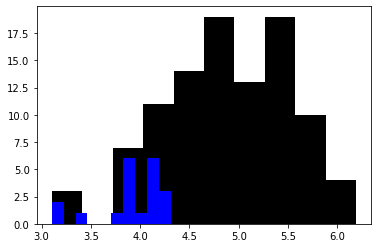

In [11]:
elites, efit = truncation_selection(population, fitness)
plt.hist(fitness, color='k')
plt.hist(efit, color='b');

To preserve genetic diversity, we'll instead allow any member of the population to have a chance of being selected, based on their fitness. One method would be to draw from the population randomly using a probability based on the fitness of each individual. This is known as fitness proportionate selection. 

In [12]:
def fp_selection(population, fitness):
    p = (np.max(fitness) - fitness)
    p /= np.sum(p)
    rng = np.random.default_rng()
    ind = rng.choice(len(population), p=p)
    return population[ind], fitness[ind]

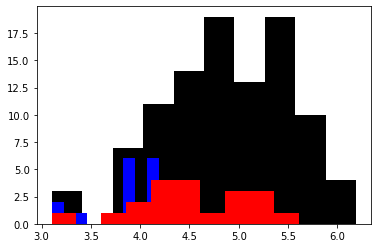

In [13]:
fp_fits = np.zeros(len(efit))
for i in range(len(efit)):
    p, f = fp_selection(population, fitness)
    fp_fits[i] = f
plt.hist(fitness, color='k')
plt.hist(efit, color='b')
plt.hist(fp_fits, color='r');

One of the desirable properties of CMA-ES was invariance to certain transformations in the search space. Because CMA-ES is based on the **order** of fitness values instead of their value, any transformation of the search space which maintains population order does not affect the search. This makes the search more generalizable to different search spaces.

Hansen, Nikolaus, et al. "Impacts of invariance in search: When CMA-ES and PSO face ill-conditioned and non-separable problems." Applied Soft Computing 11.8 (2011): 5755-5769. [pdf]

In a genetic algorithm, we can acheive the same invariance by using a random ordering of individuals. To do so, we randomly select a subset of individuals, called a tournament, and then take the best individual from that random subset. This is known as tournament selection. Because tournament selection doesn't depend on the absolute fitness value but rather the ranking of individuals in a tournament, it is also invariant to order-preserving transformations.

<div class="alert alert-success">
    <h3>Exercise 1</h3>

Complete the following tournament selection definition which uses a tournament size of `t_size=3`. Plot the selected individuals and compare it to truncation selection and fitness proportionate selection.
</div>

In [14]:
def tournament_selection(population, fitness, t_size=3):
    ind = rng.choice(len(population))
    return population[ind], fitness[ind]

In [15]:
# %load solutions/3_1_1.py

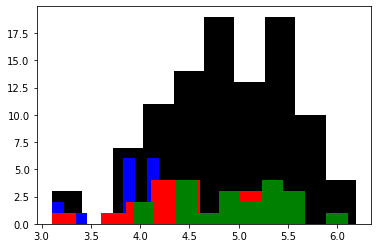

In [16]:
t_fits = np.zeros(len(efit))
for i in range(len(efit)):
    p, f = tournament_selection(population, fitness)
    t_fits[i] = f
plt.hist(fitness, color='k')
plt.hist(efit, color='b')
plt.hist(fp_fits, color='r')
plt.hist(t_fits, color='g');

## <a id="crossover"></a>Crossover

Considering we have such a large population, is there some way to combine individual solutions to lead to better solutions? For example, could we make an individual which inherits information from two parent individuals? This is the idea behind crossover, the other operator in genetic algorithms besides mutation. It is based on sexual reproduction where the genetic information of two parent individuals is mixed to create an offspring individual. The idea of combining the information from multiple individuals together to create the next generation is something we'll explore in more detail next class when discussing evolutionary strategies. For now, let's look at ways to combine two individuals.

<img src="imgs/crossover.png" width="80%" height="auto">

In [17]:
def one_point(p1, p2):
    rng = np.random.default_rng()
    x = rng.choice(np.arange(1, np.minimum(len(p1)-1, len(p2)-1)))
    return np.concatenate((p1[:x], p2[x:])), np.concatenate((p2[:x],p1[x:]))

In [18]:
parent1, _ = tournament_selection(population, fitness)
parent2, _ = tournament_selection(population, fitness)
print(parent1, parent2)
child1, child2 = one_point(parent1, parent2)
print("crossover: ")
print(child1, child2)

[1 6 0 3 2 8 5 7 4 9] [2 8 4 6 1 5 9 7 0 3]
crossover: 
[1 6 4 6 1 5 9 7 0 3] [2 8 0 3 2 8 5 7 4 9]


The one point crossover method is a common one, inspired by biology and useful for combining solutions in a number of problems. When increasing the number of swapping points beyond 1, this is known as k-point crossover, and it is useful when the problem dimensions are independent.

In the Travelling Salesman problem, however, the dimensions of the problem are not independent; there is the constraint that all cities must be visited and also that no city can be visted twice. Instead, we'll use a crossover operator which respects those constraints. This is known as the edge recombination operator and it can be applied to any directed graph recombination problem.

<img src="https://upload.wikimedia.org/wikipedia/commons/e/e5/Genetic_ero_crossover.svg" alt="Genetic ero crossover.svg" width="50%" height="auto">

https://en.wikipedia.org/wiki/Edge_recombination_operator
    
Whitley, L. Darrell, Timothy Starkweather, and D'Ann Fuquay. "Scheduling problems and traveling salesmen: The genetic edge recombination operator." ICGA. Vol. 89. 1989. [pdf](TSP_crossover.pdf)

This operator randomly selects from the neighborhood of each node. This operator is rather long to code, so we'll use the [definition](https://github.com/msu-coinlab/pymoo/blob/master/pymoo/operators/crossover/edge_recombination_crossover.py) from the [pymoo](https://pymoo.org/index.html) library. We'll use `pymoo` in the next notebook, so install it now if you haven't yet.

In [19]:
from pymoo.operators.crossover import edge_recombination_crossover as erc

print(population[0], population[1])
erc.erx(population[0], population[1])

[3 7 5 0 8 6 1 2 9 4] [0 1 4 3 2 6 7 5 9 8]


[6, 7, 3, 2, 1, 4, 9, 8, 0, 5]

## <a id="mutation"></a>Mutation

Crossover combines genetic information already existing in the population. In order to search outside the possible combinations of the population, we need to directly modify individuals. This is done using mutation, which is applied either directly to individuals from selection or, more commonly, from the new individuals created by crossover. In general, mutation operators should not greatly modify an individual, changing only a small percentage of genes. An example is uniform mutation, which randomly resamples some genes. A common mutation rate for this is `1/n_genes`, meaning that, on average, only one gene is changed.

As with crossover, we need to create a mutation operator which respects the constraints of the Travelling Salesman Problem. One such mutation operator would be to switch the order of a single random pair of cities, the same "neighbor" generating operator we discussed for Simulated Annealing.

<div class="alert alert-success">
    <h3>Exercise 2</h3>

Complete the following mutation operator definition which inverts a single random pair of cities.
</div>

In [20]:
def mutate(ind):
    return ind

In [21]:
# %load solutions/3_1_2.py

In [22]:
print(population[0], population[1])
child = erc.erx(population[0], population[1])
print(child)
mutate(child)

[3 7 5 0 8 6 1 2 9 4] [0 1 4 3 2 6 7 5 9 8]
[8, 0, 5, 9, 4, 1, 2, 6, 7, 3]


[8, 0, 5, 9, 4, 1, 2, 6, 7, 3]

In [23]:
np.concatenate((population, [population[0]]))

array([[3, 7, 5, ..., 2, 9, 4],
       [0, 1, 4, ..., 5, 9, 8],
       [7, 1, 5, ..., 6, 2, 9],
       ...,
       [1, 4, 3, ..., 5, 0, 9],
       [0, 4, 8, ..., 1, 5, 9],
       [3, 7, 5, ..., 2, 9, 4]])

In [24]:
len(population)

100

## <a id="ga"></a>The Genetic Algorithm

Now that we have all the different parts, we can combine them in the full genetic algorithm. We'll use two different selection methods: first, a truncation selection of the best few individuals which will pass directly to the next population. This is known as **elitism** and is done to preserve the best solutions between generations. Then, we'll use tournament selection to select parents for crossover. Finally, we'll mutate the result from crossover and pass this new individual into the next population.

In [25]:
def ga_step(population):
    fitness = evaluate(population, d)
    next_pop, _ = truncation_selection(population, fitness)
    while len(next_pop) < len(population):
        parent1, _ = tournament_selection(population, fitness)
        parent2, _ = tournament_selection(population, fitness)
        child = erc.erx(parent1, parent2)
        child = mutate(child)
        next_pop = np.concatenate((next_pop, [child]))
    return next_pop, fitness

In [26]:
n_cities = 20
cities = np.random.rand(n_cities, 2)
d = np.zeros((n_cities, n_cities))
for i in range(n_cities):
    for j in range(i):
        d[i, j] = np.sqrt((cities[i, 0] - cities[j, 0])**2 + (cities[i,1] - cities[j, 1])**2)
        d[j, i] = d[i, j]

In [27]:
n_population = 100
n_gen = 100
population = np.array([rng.permutation(n_cities) for i in range(n_population)])
minfit = np.zeros(n_gen)
for i in range(n_gen):
    population, fitness = ga_step(population)
    minfit[i] = np.min(fitness)
    if i > 2 and minfit[i] < minfit[i-1]:
        print(i, minfit[i])

3 6.643408589802975
4 6.442837847612925
6 6.031030373493392
7 5.662043841424372
8 4.976692142400822
17 4.183720149835587
30 4.169013914200858
31 4.093675197743183
32 4.056154572620942
34 3.780925649046254
38 3.6405888131032142
41 3.523886590590119
43 3.4860918132264023
44 3.367834305348781
49 3.2635058301370936
52 3.155404738757926
59 3.155404738757925
69 3.136046826393043
84 3.114703553316658


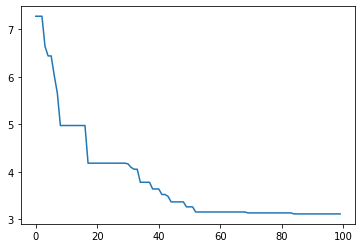

In [28]:
plt.plot(minfit);

<div class="alert alert-success">
    <h3>Exercise 3</h3>

Study two hyperparameters of the genetic algorithm: the population size and the number of elites. How do these affect the search? Are elites necessary?
</div>